In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.gridspec as gridspec

from metrics import equal_interval_ece
from losses import ECELoss,ECLoss

In [ ]:
fontsize = 30
is_normal = True
# Build training data
num_samples = 400
if is_normal:
    # normal distribution
    mean_train = [0, 0]
    cov_train  = [[1, 0], [0, 1]]
    X_train = np.random.multivariate_normal(mean_train, cov_train, num_samples)
else:
    # uniform distribution
    X_train = np.random.uniform(-2.5, 1.5, size=(num_samples, 2))

# Build test data
if is_normal:
    # normal distribution
    mean_test = [1, 1]
    cov_test  = [[1, 0], [0, 1]]
    X_test = np.random.multivariate_normal(mean_test, cov_test, num_samples)
else:
    # uniform distribution
    X_test = np.random.uniform(-1, 3, size=(num_samples, 2))

def initFun():
    '''
    Set random seed and initialize plt content
    '''
    np.random.seed(42)
    torch.manual_seed(42)
    plt.rcParams['font.family'] = 'Times New Roman'
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])
    ax4 = fig.add_subplot(gs[:, 2])
    ax1.text(0.5, -0.24, '(a) Source domain', transform=ax1.transAxes,
            ha='center', va='top', fontsize=fontsize)
    ax2.text(0.5, -0.24, '(b) Target domain', transform=ax2.transAxes,
            ha='center', va='top', fontsize=fontsize)
    ax3.text(0.5, -0.1, '(c) Calibrate using ECE', transform=ax3.transAxes,
            ha='center', va='top', fontsize=fontsize)
    ax4.text(0.5, -0.1, '(d) Calibrate using ECL (ours)', transform=ax4.transAxes,
            ha='center', va='top', fontsize=fontsize)
    ax1.tick_params(axis='both', labelsize=fontsize)
    ax2.tick_params(axis='both', labelsize=fontsize)
    ax3.tick_params(axis='both', labelsize=fontsize)
    ax4.tick_params(axis='both', labelsize=fontsize)
    xticks = [0,1]
    yticks = [0,1]
    ax3.set_xticks(xticks)
    ax3.set_yticks(yticks)
    ax4.set_xticks(xticks)
    ax4.set_yticks(yticks)
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.46)
    return ax1,ax2,ax3,ax4

def labeling_function(X):
    """
    P(Y|X)
    """
    z = np.sin(X[:, 0]) + X[:, 1] - 1.5
    probs = 1 / (1 + np.exp(-z))
    return (probs > 0.5).astype(np.int64)

def plot_data(ax,x_data,y_data,is_normal = True):
    # plot train data
    ax.scatter(x_data[y_data==0, 0], x_data[y_data==0, 1], c='red')
    ax.scatter(x_data[y_data==1, 0], x_data[y_data==1, 1], c='orange')
    if is_normal:
        ellipse_1_std = Ellipse(xy=mean_train, width=2, height=2, edgecolor='black', facecolor='none', linestyle='dashed')
        ax.add_patch(ellipse_1_std)
        ellipse_2_std = Ellipse(xy=mean_train, width=4, height=4, edgecolor='black', facecolor='none', linestyle='dashed')
        ax.add_patch(ellipse_2_std)
    x1 = np.linspace(-2.5, 3.5, 500)
    x2 = np.linspace(-2.5, 3.5, 500)
    X1, X2 = np.meshgrid(x1, x2)
    Z = np.sin(X1) + X2 - 1.5
    ax.contour(X1, X2, Z, levels=[0], colors='Blue')
    ax.legend(prop={"family": "Times New Roman","size":fontsize},framealpha=0.,loc="upper left",handlelength=0.5)
    ax.set_xlim([-2.5,3.5])
    ax.set_ylim([-2.5,3.5])


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 2) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x) 
        return x
    
def plt_Reliability_Diagram(ax,bins,bin_confs,bin_accs,ece):
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax.bar(bin_centers, bin_accs, width=(bins[1]-bins[0]), alpha=0.6, color="palegreen",edgecolor="black")
    gaps = [bin_accs[i] - bin_confs[i] for i in range(len(bin_accs))]
    ax.bar(bin_centers, gaps, width=(bins[1]-bins[0]), alpha=1.0, color="khaki", edgecolor="black", label="Gap", bottom=bin_confs)
    ax.text(0.28, 0.8, "ECE={:.3f}".format(ece), fontsize=fontsize, color='black',ha='center', va='center')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.legend(prop={"family": "Times New Roman","size":fontsize},framealpha=0.,loc="upper left",handlelength=0.5)

/tmp/ipykernel_1801454/3563559475.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(prop={"family": "Times New Roman","size":fontsize},framealpha=0.,loc="upper left",handlelength=0.5)


Epoch 10/100, Loss: 0.3886
Epoch 20/100, Loss: 0.2552
Epoch 30/100, Loss: 0.2013
Epoch 40/100, Loss: 0.1699
Epoch 50/100, Loss: 0.1452
Epoch 60/100, Loss: 0.1270
Epoch 70/100, Loss: 0.1135
Epoch 80/100, Loss: 0.1025
Epoch 90/100, Loss: 0.0931
Epoch 100/100, Loss: 0.0851
Test Accuracy: 0.8075


/home/djz/.conda/envs/For_covariate/lib/python3.11/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


Epoch 1/200, acLoss: 0.0844, ece: 0.0507, L_ce: 0.2647, Loss: 2.7824
Epoch 2/200, acLoss: 0.0842, ece: 0.0506, L_ce: 0.1951, Loss: 2.0859
Epoch 3/200, acLoss: 0.0839, ece: 0.0515, L_ce: 0.1984, Loss: 2.1195
Epoch 4/200, acLoss: 0.0837, ece: 0.0477, L_ce: 0.1530, Loss: 1.6617
Epoch 5/200, acLoss: 0.0835, ece: 0.0475, L_ce: 0.2153, Loss: 2.2839
Epoch 6/200, acLoss: 0.0833, ece: 0.0501, L_ce: 0.1987, Loss: 2.1200
Epoch 7/200, acLoss: 0.0831, ece: 0.0540, L_ce: 0.1080, Loss: 1.2171
Epoch 8/200, acLoss: 0.0829, ece: 0.0523, L_ce: 0.1124, Loss: 1.2594
Epoch 9/200, acLoss: 0.0828, ece: 0.0535, L_ce: 0.1381, Loss: 1.5170
Epoch 10/200, acLoss: 0.0826, ece: 0.0504, L_ce: 0.1548, Loss: 1.6806
Epoch 11/200, acLoss: 0.0825, ece: 0.0505, L_ce: 0.2411, Loss: 2.5438
Epoch 12/200, acLoss: 0.0823, ece: 0.0542, L_ce: 0.1403, Loss: 1.5395
Epoch 13/200, acLoss: 0.0822, ece: 0.0501, L_ce: 0.1803, Loss: 1.9350
Epoch 14/200, acLoss: 0.0820, ece: 0.0501, L_ce: 0.1546, Loss: 1.6781
Epoch 15/200, acLoss: 0.0818,

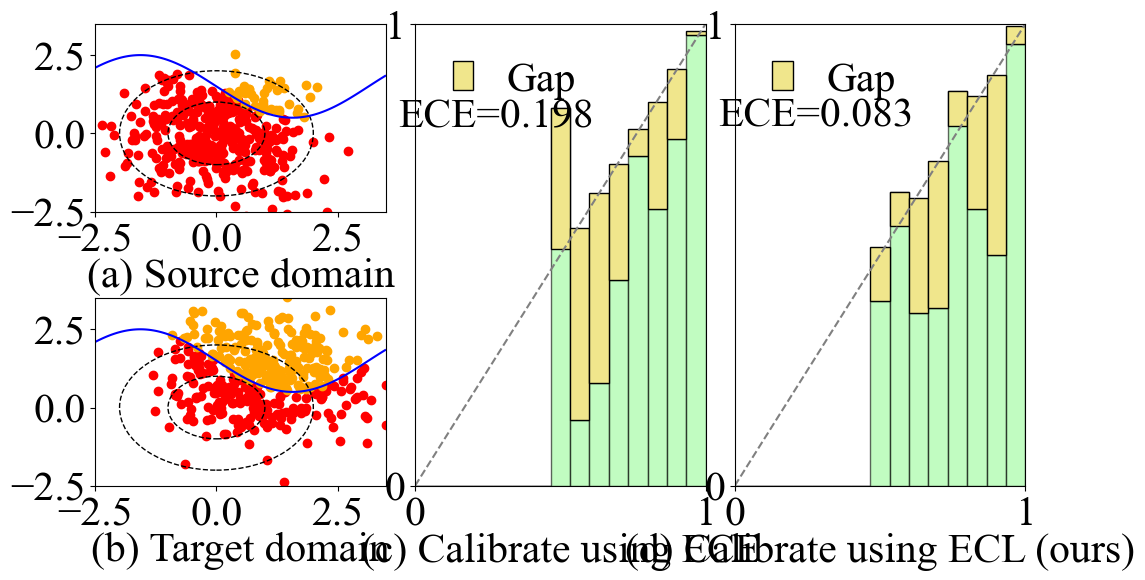

Success!


In [3]:
ax1,ax2,ax3,ax4 = initFun()

y_train = labeling_function(X_train)
plot_data(ax1,X_train,y_train,is_normal)

y_test = labeling_function(X_test)
plot_data(ax2,X_test,y_test,is_normal)

# to tenser
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)

# Training
model = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        train_preds = torch.argmax(outputs, dim=1)
        train_probs = torch.softmax(outputs, dim=1).max(dim=1).values
        #ece = ECELoss()(train_probs,train_preds==batch_y)
        ece = ECELoss()(train_probs,train_preds==batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")
model.eval()
with torch.no_grad():
    test_logits = model(X_test_tensor) 
    test_probs_all = torch.softmax(test_logits, dim=1)
    test_preds = torch.argmax(test_probs_all, dim=1).cpu().numpy()
    test_labels = y_test_tensor.cpu().numpy()
    test_accuracy = np.mean(test_preds == test_labels)
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    test_probs = test_probs_all.max(dim=1).values.cpu().numpy()

# compute ECE and plot reliability diagram
ece, bins, bin_confs, bin_accs, bin_counts = equal_interval_ece(test_probs, test_preds==test_labels, num_bins=15)
plt_Reliability_Diagram(ax3,bins,bin_confs,bin_accs,ece)

# Calibration with Expectation consistency loss
num_epochs = 200
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

ecLoss = ECLoss(X_train_tensor,X_test_tensor,model)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_accLoss = 0.0
    epoch_ece = 0.0
    epoch_Lce = 0.0

    for (train_X, train_y), (test_X, _) in zip(train_loader, test_loader):
        train_output = model(train_X)
        train_preds = torch.argmax(train_output, dim=1)
        train_probs = torch.softmax(train_output, dim=1).max(dim=1).values
        test_output = model(test_X)
        test_preds = torch.argmax(test_output, dim=1).cpu().numpy()
        test_probs = torch.softmax(test_output, dim=1).max(dim=1).values
        accLoss = criterion(train_output,train_y)
        ece = ECELoss()(train_probs,train_preds==train_y)
        L_ce = ecLoss(train_X,train_y,train_preds,train_probs,test_probs) 
        loss = accLoss+ece+10*L_ce
        loss.backward(retain_graph=True)
        optimizer.step()
        epoch_accLoss += accLoss.item()
        epoch_ece += ece.item()
        epoch_Lce += L_ce.item()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, acLoss: {epoch_accLoss / min(len(train_loader),len(test_loader)):.4f}, ece: {epoch_ece / min(len(train_loader),len(test_loader)):.4f}, L_ce: {epoch_Lce / min(len(train_loader),len(test_loader)):.4f}, Loss: {epoch_loss / min(len(train_loader),len(test_loader)):.4f}")

model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    test_preds = torch.argmax(test_output, dim=1).cpu().numpy()
    test_probs = torch.softmax(test_output, dim=1).max(dim=1).values
ece, bins, bin_confs, bin_accs, bin_counts = equal_interval_ece(test_probs.cpu().detach().numpy(), test_preds == y_test_tensor.cpu().detach().numpy(), num_bins=15)
plt_Reliability_Diagram(ax4,bins,bin_confs,bin_accs,ece)
plt.show()
print("Success!")